In [ ]:
#default_exp losses.gw_test

In [ ]:
#hide
%load_ext autoreload
%autoreload 2

# Giacomini-White Test

Test on out-of-sample conditional predictive ability.

References:
- Giacomini, R., & White, H. (2006). Tests of conditional predictive ability. Econometrica, 74(6), 1545-1578.
- https://onlinelibrary.wiley.com/doi/abs/10.1111/j.1468-0262.2006.00718.x
- http://www.runmycode.org/companion/view/88

## Newey-West estimator

Estimator of the Newey-West Heteroskedasticity and Autocorrelation Consistent Covariance Matrix (Newey-West HAC) to calculate robust error estimations.

In [ ]:
#export
import os
import numpy as np
from scipy.stats.distributions import chi2

from typing import List

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable

from matplotlib import rcParams
plt.rcParams['font.family'] = 'serif'

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

FONTSIZE = 17

In [ ]:
# export
def Newey_West(Z, n_lags):
    """ Newey-West HAC estimator
    Parameters
    ----------
    Z: (n, k) ndarray
    n_lags: int
        number of lags to consider as available information.

    Returns
    -------
    omega_hat: Newey-West HAC estimator of the covariance matrix
    """

    assert n_lags > 0

    n, k = Z.shape

    Z = Z - np.ones((n, 1)) * np.mean(Z, axis=0)
    gamma = -999 * np.ones((n_lags, k))
    omega_hat = (1/n) * np.matmul(np.transpose(Z), Z)

    Zlag = np.array([np.pad(Z, ((i,0), (0,0)), mode='constant', 
                            constant_values = 0)[:n] 
                     for i in range(1, n_lags + 1)])
    gamma = (1/n) * (np.matmul(np.transpose(Z), Zlag) + 
            np.matmul(np.einsum('ijk -> ikj', Zlag), Z))
    weights = 1 - np.array(range(1,n_lags + 1))/(n_lags + 1)
    omega_hat = omega_hat + \
                np.sum(gamma * np.expand_dims(weights, 
                                              axis = (1,2)), 
                                              axis = 0)
    return omega_hat

In [ ]:
# export
def GW_CPA_test(loss1: np.ndarray, 
                loss2: np.ndarray, 
                tau: int,
                alpha: float=0.05,
                conditional: bool=False,
                verbose: bool=True):
    """ 
    Giacomini-White Conditional Predictive Ability Test
    Parameters
    ----------
    loss1: numpy array
        losses of model 1
    loss2: numpy array
        losses of model 2
    tau: int
        the past information treated as 'available' for the test.
    unconditional: boolean, 
        True if unconditional (DM test), False if conditional (GW test).
    verbose: boolean, 
        True if prints of test are needed

    Returns
    -------
    test_stat: test statistic of the conditional predictive ability test
    crit_val: critical value of the chi-square test for a 5% confidence level
    p-vals: (k,) p-value of the test
    """   

    assert len(loss1) == len(loss2)

    lossdiff = loss1 - loss2
    t = len(loss1)
    instruments = np.ones_like(loss1)

    if conditional:
        instruments = np.hstack((instruments[:t-tau], 
                                 lossdiff[:-tau]))
        lossdiff = lossdiff[tau:]
        t = t - tau

    reg = instruments * lossdiff
    
    if tau == 1:

        res_beta = np.linalg.lstsq(reg, np.ones((t)), rcond=None)[0]

        err = np.ones((t,1)) - reg.dot(res_beta)
        r2 = 1 - np.mean(err**2)
        test_stat = t * r2
    
    else:

        zbar = np.mean(reg, axis=0)
        n_lags = tau - 1
        omega = Newey_West(Z=reg, n_lags=n_lags)
        test_stat = np.expand_dims(t*zbar, 
                                   axis=0).dot(np.linalg.inv(omega)).\
                                   dot(zbar)
      
    test_stat *= np.sign(np.mean(lossdiff))
    
    q = reg.shape[1]
    crit_val = chi2.ppf(1-alpha, df=q)
    p_val = 1 - chi2.cdf(test_stat, q)

    av_diff_loss = np.mean(loss1-loss2)
    s = '+' if np.mean(loss1-loss2) > 0 else '-'
    
    if verbose:
        if conditional: print('\nConditional test:\n')
        if not conditional: print('\nUnconditional test:\n')
        print(f'Forecast horizon: {tau}, Nominal Risk Level: {alpha}')
        print(f'Test-statistic: {test_stat} ({s})')
        print(f'Critical value: {crit_val}')
        print(f'p-value: {p_val}\n')
    
    return test_stat, crit_val, p_val


In [ ]:
np.random.seed(1)

loss1 = np.random.randint(low=1, high=10, size=(10,1))
loss2 = np.random.randint(low=1, high=10, size=(10,1))

GW_CPA_test(loss1=loss1, loss2=loss2, tau=1, conditional=True)


Conditional test:

Forecast horizon: 1, Nominal Risk Level: 0.05
Test-statistic: -0.06536064947319775 (-)
Critical value: 5.991464547107979
p-value: 1.0



(-0.06536064947319775, 5.991464547107979, 1.0)

In [ ]:
# export
def GW_test_pvals(y: np.ndarray,
                  y_hat: np.ndarray,
                  horizon: int,
                  tau: int,                
                  conditional: bool,
                  alpha: float=0.05,
                  verbose: bool=False):
    """ Function to calculate model-pair-wise GW-Test p-values
    Parameters
    ----------
    y: numpy array
        flat array with actual test values
    y_hat: numpy array
        matrix with predicted values
    model_names: string list 
        with the names of the models.
    horizon: int
        the multi horizon for which the predictions were created, 
        the test is performed against over the mean differences 
        in said multi horizon losses.
    tau: int
        the past information treated as 'available' for the test.
    alpha: float 
        level of significance for the test.
    unconditional: boolean, 
        True if unconditional (DM test), False if conditional (GW test).
    verbose: boolean.
        True for partial test results.

    Returns
    -------
    p_vals: (n_models, n_models) 
            symmetric numpy array with the model-pair-wise p-values.
    
    """
    # number of date stamps and de facto forecast creation dates
    y_hat = y_hat.T # transpose for good reshape indexes
    n_models, n_ds = y_hat.shape
    n_fcds = n_ds // horizon

    # multi horizon losses
    losses = np.abs(y - y_hat)

    print("losses.shape", losses.shape)
    print("n_models, n_ds, n_fcds")
    print(n_models, n_ds, n_fcds)

    losses = losses.reshape(n_models, n_fcds, horizon)
    losses = np.mean(losses, axis=2)

    print("losses.shape", losses.shape)

    pvals = np.zeros((n_models, n_models))

    for i in range(n_models):
        for j in range(n_models):
            loss1 = losses[[i], :]
            loss2 = losses[[j], :]
            _, _, p_val = GW_CPA_test(loss1=loss1.reshape(n_fcds, -1),
                                      loss2=loss2.reshape(n_fcds, -1),
                                      tau=1,
                                      alpha=alpha,
                                      conditional=conditional,
                                      verbose=verbose)

            pvals[i,j] = p_val

    return pvals

In [ ]:
# export
def get_nbeatsx_cmap():
    cmap = cm.get_cmap('pink', 512)
    yellows = cmap(np.linspace(0.5, 0.95, 256))

    cmap = cm.get_cmap('Blues', 256)
    blues = cmap(np.linspace(0.45, 0.75, 256))

    newcolors = np.concatenate([yellows, blues])

    #extra = np.array([116/256, 142/256, 157/256, 1])
    extra = np.array([66/256, 75/256, 98/256, 1])
    #extra = np.array([3/256, 34/256, 71/256, 1])
    newcolors[-10:, :] = extra
    newcmap = ListedColormap(newcolors)
    return newcmap

def get_epftoolbox_cmap():
    cmap = cm.get_cmap('YlGn_r', 512)
    yellows = cmap(np.linspace(0.6, 1.0, 256))

    cmap = cm.get_cmap('gist_heat_r', 256)
    reds = cmap(np.linspace(0.39, 0.66, 256))

    newcolors = np.concatenate([yellows, reds])

    #extra = np.array([116/256, 142/256, 157/256, 1])
    #extra = np.array([66/256, 75/256, 98/256, 1])
    #extra = np.array([3/256, 34/256, 71/256, 1])
    extra = np.array([0, 0, 0, 1])
    newcolors[-10:, :] = extra
    newcmap = ListedColormap(newcolors)
    return newcmap

def plot_GW_test_pvals(pvals, labels, title):
    assert len(pvals)==len(labels), 'Wrong pvals and labels dimensions.'

    #plt.rc('text', usetex=True)
    plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
    plt.rc('axes', titlesize=16)  # fontsize of the figure title

    fig = plt.figure(figsize=[6, 6])
    ax = plt.axes([.27, .22, .7, .7])

    data = np.float32(pvals)

    # Colormap with discontinuous limit
    #cmap = cm.get_cmap('GnBu', 256)
    #cmap = get_nbeatsx_cmap()
    cmap = get_epftoolbox_cmap()
    mappable = plt.imshow(data, cmap=cmap, vmin=0, vmax=0.1)

    ticklabels = labels #[r'$\textrm{' + e + '}$' for e in labels]
    plt.xticks(range(len(labels)), ticklabels, rotation=90., fontsize=FONTSIZE)
    plt.yticks(range(len(labels)), ticklabels, fontsize=FONTSIZE)

    plt.plot(list(range(len(labels))), 
             list(range(len(labels))), 'wx', c='white', markersize=FONTSIZE)
    plt.title(f'{title}', fontweight='bold', fontsize=FONTSIZE)

    # Turn spines off and create black grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="k", linestyle='-', linewidth=1.5)

    # Colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(mappable, cax=cax)

    #fig.tight_layout()
    title = title.replace(" ", "_")
    title = title.replace(",", "")
    title = title.replace("(", "")
    title = title.replace(")", "")
    plt.savefig(f'./results/pvals_{title}.pdf', bbox_inches='tight')
    plt.show()

# TEST/DEBUG GW TEST

losses.shape (5, 2400)
n_models, n_ds, n_fcds
5 2400 100
losses.shape (5, 100)


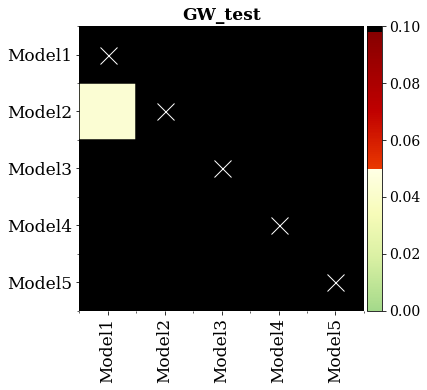

In [ ]:
np.random.seed(117)

# Observed values for 3 different days
y = np.random.randint(low=1, high=10, size=(100*24)) 

# Predicted values for 3 different days, from 5 different models
y_hat = np.random.randint(low=1, high=10, size=(100*24, 5))
model_names = ['Model1', 'Model2', 'Model3', 'Model4', 'Model5']

pvals = GW_test_pvals(y=y, y_hat=y_hat, horizon=24, tau=1,
                      conditional=True, alpha=0.05, verbose=False)

plot_GW_test_pvals(pvals=pvals, labels=model_names, title='GW_test')

In [ ]:
# import pandas as pd

# data = pd.read_csv('./results/ver.csv')

# model_names = ['AR1', 'ESRNN', 'NBEATS', 'ARX1', 'LEAR', 'DNN', 'NBEATS_X_G', 'NBEATS_X_I']
# pvals = GW_test_pvals(y=np.expand_dims(data['y'].to_numpy(), axis=0),
#                       y_hat=data.loc[:, model_names].to_numpy(),
#                       horizon=24,
#                       tau=1,
#                       conditional=True,
#                       alpha=0.05,
#                       verbose=False)

# plot_GW_test_pvals(pvals=pvals, labels=model_names, title='GW_test')